# Implementation of CNFs

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import numpy.random as npr
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

In [4]:
from cnf import CNF
from neural_ode import NeuralODE
from sklearn.datasets import make_moons

## Create CNFs - ensemble of multiple flow layers

In [5]:
num_samples = 512
cnf_net = CNF(input_dim=2, hidden_dim=32, n_ensemble=16)
ode = NeuralODE(model=cnf_net, t=np.linspace(0, 1, 10))

In [6]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-2, beta2=0.99)

In [7]:
def compute_gradients_and_update(h0):    
    hN = ode.forward(inputs=h0)
    with tf.GradientTape() as g:
        g.watch(hN)
        xN, logdetN = hN[:, :2], hN[:, 2]
        # L = log(p(zN))
        mle = tf.reduce_sum(p0.log_prob(xN), -1)
        # normally we maximize: log(p(z)) - logdetJ
        loss = - tf.reduce_mean(mle - logdetN)
    
    dloss = g.gradient(loss, hN)
    h0_rec, dLdh0, dLdW = ode.backward(hN, dloss)          
    optimizer.apply_gradients(zip(dLdW, cnf_net.weights))
    return loss


compute_gradients_and_update = tfe.defun(compute_gradients_and_update)

## Define targer distribution p0 -> Gaussian

In [8]:
# test points
p0 = tf.distributions.Normal(loc=[0.0, 0.0], scale=[1.0, 1.0])
points, classes = make_moons(n_samples=num_samples, noise=0.08)
x0_test = tf.to_float(points)
logdet0 = tf.zeros([num_samples, 1])
h0_test = tf.concat([x0_test, logdet0], axis=1)  

In [9]:
loss_history = []
for step in tqdm(range(1100)):
    
    # sample points from two moons dataset
    x0 = tf.to_float(make_moons(n_samples=num_samples, noise=0.08)[0])
    logdet0 = tf.zeros([num_samples, 1])
    h0 = tf.concat([x0, logdet0], axis=1)    
    loss = compute_gradients_and_update(h0)
    loss_history.append(loss.numpy())
    if step % 10 == 0:
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.plot(loss_history)
        plt.subplot(132)
        hN = ode.forward(h0_test)
        xN, logdetN = hN[:, :2], hN[:, 2]        
        plt.title("Source points")
        plt.scatter(*x0_test.numpy().T, c=classes, alpha=0.5, cmap='jet')   
        plt.axis("equal")
        plt.xlim([-1, 1.5])
        plt.ylim([-1, 1])
        plt.subplot(133)        
        plt.title("Target p0")
        plt.scatter(*xN.numpy().T, c=classes, alpha=0.5, cmap='jet')   
        plt.axis("equal")        
        plt.xlim([-2.5, 2.5])
        plt.ylim([-2.5, 2.5])
        plt.savefig(f"cnfs/training/step_{1000 + step}.jpg")
        plt.clf()
        plt.cla()
        plt.close()

100%|██████████| 1100/1100 [02:24<00:00,  7.62it/s]


## Test reconstruction of points: two moons -> gaussian -> two moons

In [10]:
# sample points from two moons
x0 = tf.to_float(make_moons(n_samples=num_samples, noise=0.08)[0])
logdet0 = tf.zeros([num_samples, 1])
h0 = tf.concat([x0, logdet0], axis=1)
# forward -> backward
hN = ode.forward(inputs=h0)
h0_reconstruction, *_ = ode.backward(outputs=hN)

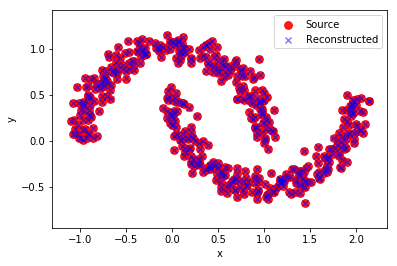

In [11]:
plt.scatter(*x0.numpy().T, color='r', alpha=0.9, label="Source", s=60)
plt.scatter(*h0_reconstruction[:, :2].numpy().T, color='b', alpha=0.5, marker='x', label="Reconstructed")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
_ = plt.axis("equal")

## Sample points:

In [31]:
# use the same ode solver to sample: note backward method is used
p0 = tf.distributions.Normal(loc=[0.0, 0.0], scale=[1.0, 1.0])
hN_sample = tf.concat([p0.sample(num_samples), logdet0], axis=1)
h0_sample, *_ = ode.backward(outputs=hN_sample)
# another way of sampling
t_grid = np.linspace(1, 0, 100)
reverse_ode = NeuralODE(model=cnf_net, t=t_grid)
hN_sample = tf.concat([p0.sample(num_samples), logdet0], axis=1)
h0_sample, ht_hist = reverse_ode.forward(hN_sample, return_states="numpy")

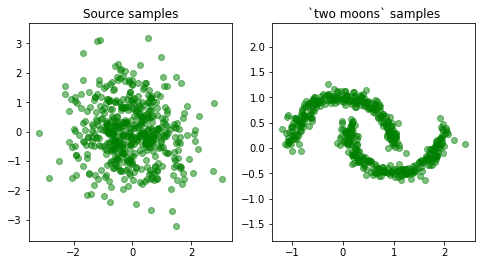

In [32]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title("Source samples")
plt.scatter(*hN_sample[:, :2].numpy().T, color='g', alpha=0.5)
_ = plt.axis("equal")
plt.subplot(122)
plt.title("`two moons` samples")
plt.scatter(*h0_sample[:, :2].numpy().T, color='g', alpha=0.5)
_ = plt.axis("equal")

In [38]:
for step, (t, ht) in enumerate(zip(t_grid, ht_hist)):
    plt.figure(figsize=(5, 5))    
    plt.title(f"t={t:5.2f}")
    plt.scatter(*ht[:, :2].T, color='g', alpha=0.5)
    _ = plt.axis("equal")
    plt.xlim([-2.5, 2.5])
    plt.ylim([-2.5, 2.5])
    plt.savefig(f"cnfs/interpolation/step_{1000 + step}.jpg")
    plt.close()

## Transormed probablity density function

In [47]:
# Create grid of points
vx = np.linspace(-2.5, 2.5, 100)
vy = np.linspace(-2.5, 2.5, 100)
# points.shape == (10000, 2)
points = np.vstack(np.meshgrid(vx, vy)).reshape([2, -1]).T

x0 = tf.to_float(points)
logdet0 = tf.zeros([points.shape[0], 1])
h0_sample = tf.concat([x0, logdet0], axis=1)  # => (1000, 4)

ode_dens = NeuralODE(model=cnf_net, t=np.linspace(0, 1, 50))
h0_reconstruction, ht_hist = ode_dens.forward(h0_sample, return_states="numpy")
for step, (t, ht) in enumerate(zip(np.linspace(0, 1, 50), ht_hist)):
    x0_rec, x0_logdet = ht[:, :2], ht[:, 2]
    logp = tf.reduce_sum(p0.log_prob(x0_rec), -1) - x0_logdet

    plt.figure(figsize=(5, 5))
    plt.title("Target distribution")
    plt.tricontourf(*x0.numpy().T, np.exp(logp.numpy()), 200, cmap='jet')
    _ = plt.axis("equal")
    plt.xlim([vx.min(), vx.max()])
    plt.ylim([vy.min(), vy.max()])
    plt.savefig(f"cnfs/density/step_{1000 + step}.jpg")
    plt.close()

# Reimplementation of Fig. 4 of paper

Comparison of normalizing flows versus continuous normalizing flows

In [15]:
vx = np.linspace(-5, 5, 100)
vy = np.linspace(-5, 5, 100)
points = np.vstack(np.meshgrid(vx, vy)).reshape([2, -1]).T

In [16]:
def w1(z):
    return tf.sin(2.*np.pi*z[0]/4.)
def w2(z):
    return 3.*tf.exp(-.5*(((z[0]-1.)/.6))**2)
def w3(z):
    return 3.*(1+tf.exp(-(z[0]-1.)/.3))**-1

def potential_energy(z):
    z = tf.transpose(z)
    return .5*((tf.norm(z, ord=2, axis=0) - 2.)/.4)**2 \
        - tf.log(tf.exp(-.5*((z[0]-2.)/.6)**2) + tf.exp(-.5*((z[0]+2.)/.6)**2))

Target density:

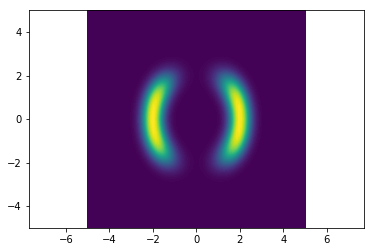

In [17]:
probs = potential_energy(tf.to_float(points)).numpy()
plt.tricontourf(points[:, 0], points[:, 1], np.exp(-probs), 100)
plt.xlim([-5, 5])
plt.ylim([-5, 5])
_ = plt.axis('equal') 

## Define CNFs

In [18]:
num_samples = 512
cnf_net = CNF(input_dim=2, hidden_dim=32, n_ensemble=32)
ode = NeuralODE(model=cnf_net, t=np.linspace(0, 1, 10))

## Train model with MLE method

In [19]:
def compute_gradients_and_update(h0, optimizer):
    hN = ode.forward(inputs=h0)
    with tf.GradientTape() as g:
        g.watch(hN)
        xN, logdetN = hN[:, :2], hN[:, 2]
        # L = log(p(xN)) = log(-E(xN))
        mle = - potential_energy(xN)
        # loss to minimize
        loss = - tf.reduce_mean(mle - logdetN)

    dloss = g.gradient(loss, hN)
    h0_rec, dLdh0, dLdW = ode.backward(hN, dloss)          
    optimizer.apply_gradients(zip(dLdW, cnf_net.weights))
    return loss

compute_gradients_and_update = tfe.defun(compute_gradients_and_update)

In [20]:
loss_history = []

In [21]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3, beta2=0.99)

  0%|          | 0/1001 [00:00<?, ?it/s]

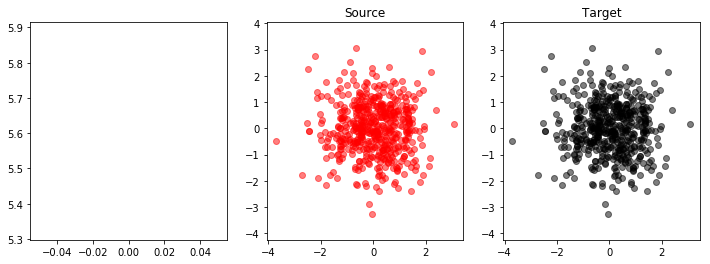

 20%|█▉        | 200/1001 [00:37<02:32,  5.27it/s]

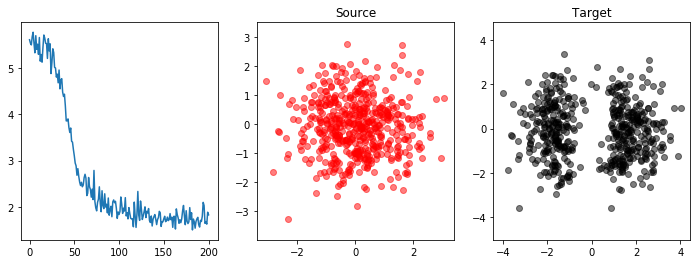

 40%|███▉      | 400/1001 [01:01<01:32,  6.49it/s]

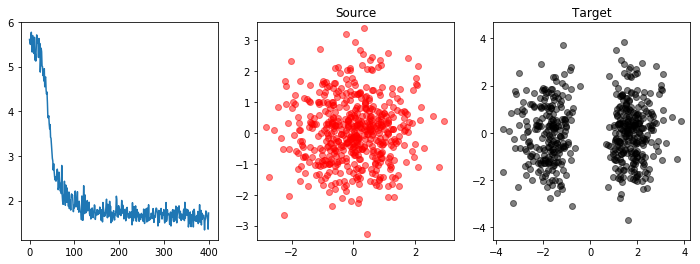

 60%|█████▉    | 600/1001 [01:25<00:57,  7.00it/s]

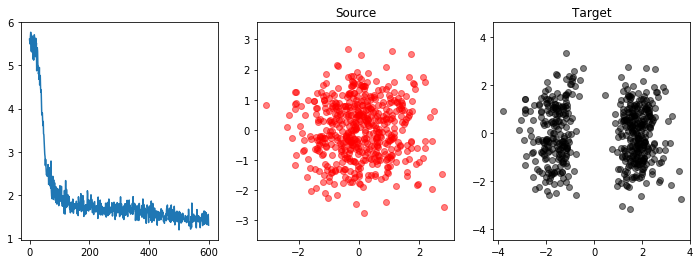

 80%|███████▉  | 800/1001 [01:49<00:27,  7.31it/s]

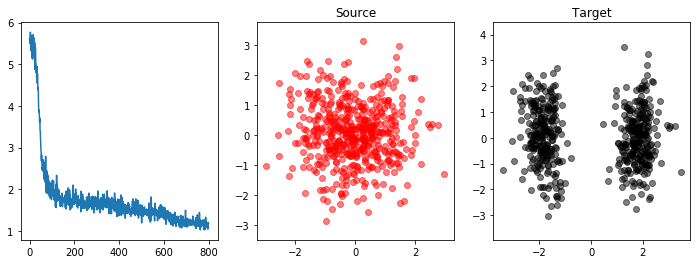

100%|█████████▉| 1000/1001 [02:12<00:00,  7.53it/s]

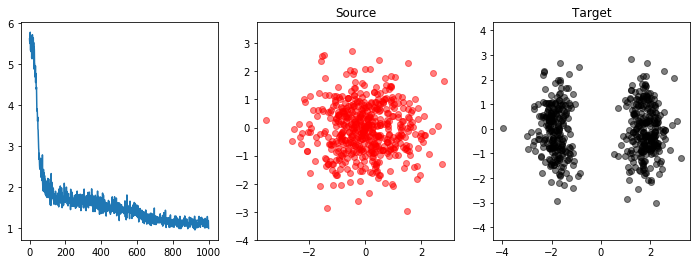

100%|██████████| 1001/1001 [02:13<00:00,  7.50it/s]


In [22]:
for step in tqdm(range(1001)):
    logdet0 = tf.zeros([num_samples, 1])
    x0 = tf.random_normal([num_samples, 2])
    h0 = tf.concat([x0, logdet0], axis=1)
    
    loss = compute_gradients_and_update(h0, optimizer)
    loss_history.append(loss.numpy())
    if step % 200 == 0:
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.plot(loss_history)
        plt.subplot(132)
        hN = ode.forward(h0)
        xN, logdetN = hN[:, :2], hN[:, 2]        
        plt.title("Source")
        plt.scatter(*x0.numpy().T, color='r', alpha=0.5)        
        plt.axis("equal")
        plt.subplot(133)
        plt.title("Target")        
        plt.scatter(*xN.numpy().T, color='k', alpha=0.5)
        plt.axis("equal")
        plt.show()

## Final probablity density function

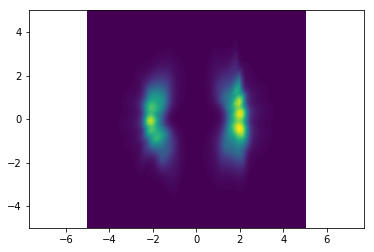

In [23]:
# grid
x = np.linspace(-5, 5, 80)
y = np.linspace(-5, 5, 80)
xv, yv = np.meshgrid(x, y)
xy = tf.to_float(np.concatenate([xv, yv]).reshape([2, -1]).T)

# source distribution
p0 = tf.distributions.Normal(loc=[0.0, 0.0], scale=[1.0, 1.0])

logdet0 = tf.zeros([xy.shape[0], 1])
h0 = tf.to_float(tf.concat([xy, logdet0], axis=1))
hN, *_ = ode.backward(h0)
xN, logdetN = hN[:, :2], hN[:, 2]


logp = tf.reduce_sum(p0.log_prob(xN), -1) - logdetN
plt.tricontourf(*xy.numpy().T, np.exp(logp.numpy()), 200)
_ = plt.axis("equal")

## Sample points

In [24]:
from neural_ode import defun_neural_ode
defun_ode = defun_neural_ode(ode)

In [25]:
logdet0 = tf.zeros([num_samples, 1])
events = []
for i in tqdm(range(1000)):
    x0 = tf.random_normal([num_samples, 2])
    h0 = tf.concat([x0, logdet0], axis=1)
    hN = defun_ode.forward(h0)
    xN, logdetN = hN[:, :2], hN[:, 2]
    events.append(xN.numpy())
    
hN_samples = np.concatenate(events)

100%|██████████| 1000/1000 [00:33<00:00, 29.59it/s]


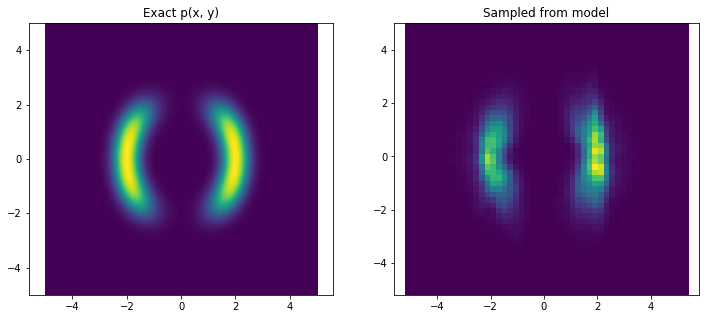

In [26]:
vx = np.linspace(-5, 5, 100)
vy = np.linspace(-5, 5, 100)
points = np.vstack(np.meshgrid(vx, vy)).reshape([2, -1]).T
probs = potential_energy(tf.to_float(points)).numpy()

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title("Exact p(x, y)")
plt.tricontourf(points[:, 0], points[:, 1], np.exp(-probs), 100)
plt.axis('equal') 

plt.xlim([-5, 5])
_ = plt.ylim([-5, 5])
plt.subplot(122)
plt.title("Sampled from model")
_ = plt.hist2d(hN_samples[:, 0], hN_samples[:, 1], 50)
_ = plt.axis('equal')